# Overview

Using the e-commerce data we will attempt to do a customer segmentation by creating new features as predictors that later can be applied to customers. Expected output = customer segments

[UK e-commerce dataset](https://www.kaggle.com/carrie1/ecommerce-data)

In [ ]:
!pip install plotly-express
!pip install yellowbrick

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
%matplotlib inline

from itertools import product
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import silhouette_visualizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Connect to Dataset on Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Final Project

/content/gdrive/MyDrive/Colab Notebooks/Final Project


In [ ]:
# Read Data
df = pd.read_csv('data.csv',encoding="ISO-8859-1", dtype={'CustomerID': str, 'InvoiceID': str})
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (541909, 8)


In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


# Data Preprocessing

In [ ]:
#Dataset info
def data_info (df):
  info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
  info=info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
  info=info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
  print('Dataframe dimensions:', df.shape)
  print('Duplicate entries:', df.duplicated().sum())
  return info

data_info(df)

Dataframe dimensions: (541909, 8)
Duplicate entries: 5268


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,object,float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


Customer ID and Description columns have missing values

In [ ]:
#Data Cleansing
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) #change to datetime
df.dropna(subset = ['CustomerID'], inplace = True) #drop NA
df.drop_duplicates(inplace = True) #drop duplicates
df = df[df["Quantity"] > 0] #remove 0 or negative Quantity (Possibly Cancellation etc.)
df = df[df["UnitPrice"] > 0] #remove 0 UnitPrice (Possibly Free Items)
df = df[df["InvoiceNo"].str.contains("C")==False] #remove cancelled orders
data_info(df)

Dataframe dimensions: (392692, 8)
Duplicate entries: 0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.sample(8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
403318,571560,22192,BLUE DINER WALL CLOCK,2,2011-10-18 09:54:00,8.50,14897,United Kingdom
222093,556330,23132,SMALL IVORY HEART WALL ORGANISER,1,2011-06-10 11:29:00,5.75,17797,United Kingdom
164421,550639,20724,RED RETROSPOT CHARLOTTE BAG,10,2011-04-19 15:46:00,0.85,14152,United Kingdom
337084,566427,21485,RETROSPOT HEART HOT WATER BOTTLE,1,2011-09-12 14:24:00,4.95,17433,United Kingdom
28633,538652,16008,SMALL FOLDING SCISSOR(POINTED EDGE),12,2010-12-13 15:12:00,0.25,17890,United Kingdom
286117,562021,22720,SET OF 3 CAKE TINS PANTRY DESIGN,6,2011-08-01 15:37:00,4.95,16172,United Kingdom
527436,580720,21891,TRADITIONAL WOODEN SKIPPING ROPE,1,2011-12-05 16:55:00,1.45,14629,United Kingdom
231076,557232,21880,RED RETROSPOT TAPE,12,2011-06-17 14:28:00,0.65,12463,Belgium


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  object        
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.0+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice
count,392692.000000,392692.000000
mean,13.119702,3.125914
std,180.492832,22.241836
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


# Data Exploration

In [ ]:
#Basic Info
pd.DataFrame([{'Products': len(df['StockCode'].value_counts()),    
               'Transactions': len(df['InvoiceNo'].value_counts()),
               'Customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['Products', 'Transactions', 'Customers'], index = ['Quantity'])

,Products,Transactions,Customers
Quantity,3665,18532,4338


In [ ]:
#New column for sales
df['Sales'] = df['Quantity'] * df['UnitPrice']
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [ ]:
#DataFrame for EDA
eda = df.copy()
eda.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [ ]:
#Make Columns for Transaction Year Month Day
eda['YearMonth'] = eda['InvoiceDate'].map(lambda x: 100*x.year + x.month)
eda['Month'] = eda.InvoiceDate.dt.month
eda['Day'] = (eda.InvoiceDate.dt.dayofweek)+1
eda['Hour'] = eda.InvoiceDate.dt.hour
eda.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,YearMonth,Month,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,201012,12,3,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,201012,12,3,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,201012,12,3,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,201012,12,3,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,201012,12,3,8


In [ ]:
#Transaction Periods
eda_orders = eda.groupby(by='YearMonth', as_index=False)['InvoiceNo'].count()
eda_orders

,YearMonth,InvoiceNo
0,201012,25670
1,201101,20988
2,201102,19706
3,201103,26870
4,201104,22433
5,201105,28073
6,201106,26926
7,201107,26580
8,201108,26790
9,201109,39669


Transactions recorded ranges from December 2010 to December 2011

In [ ]:
#Transaction Periods
eda_sales = eda.groupby(by='YearMonth', as_index=False)['Sales'].sum()
eda_sales

,YearMonth,Sales
0,201012,570422.730
1,201101,568101.310
2,201102,446084.920
3,201103,594081.760
4,201104,468374.331
5,201105,677355.150
6,201106,660046.050
7,201107,598962.901
8,201108,644051.040
9,201109,950690.202


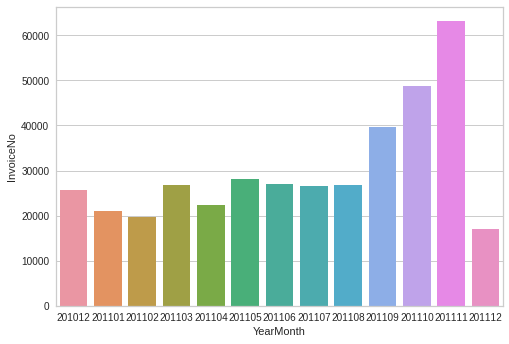

In [ ]:
#Sales & Number of Orders by YearMonth
ax = sns.barplot(x="YearMonth", y='InvoiceNo', data=eda_orders)

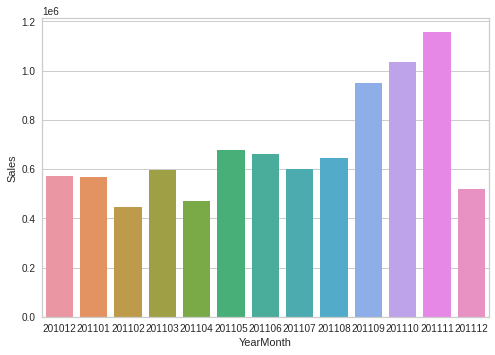

In [ ]:
ax = sns.barplot(x="YearMonth", y='Sales', data=eda_sales)

November 2011 Highest Number of Orders and Sales

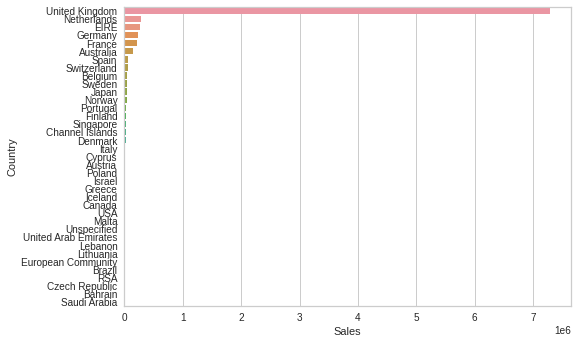

In [ ]:
#Sales by Country (UK Included)
x = eda.groupby(by='Country', as_index=False)['Sales'].sum().sort_values('Sales',ascending=False)
sns.barplot(y='Country', x='Sales', data=x, orient='h')

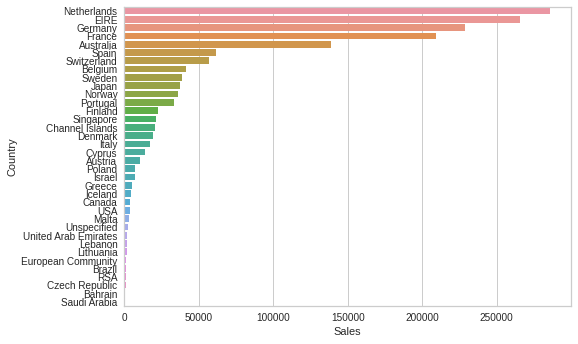

In [ ]:
#Sales by Country (UK Excluded)
x = eda.groupby(by='Country', as_index=False)['Sales'].sum().sort_values('Sales',ascending=False)
x = x[x['Country'] != 'United Kingdom']
sns.barplot(y='Country', x='Sales', data=x, orient='h')

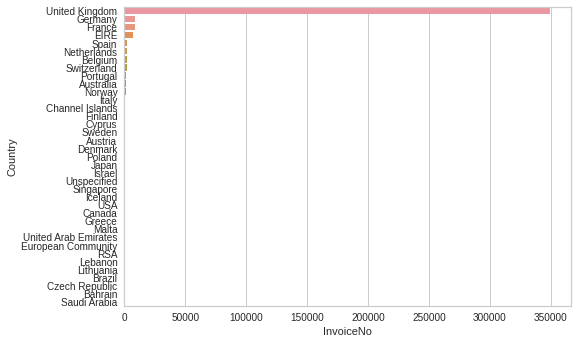

In [ ]:
#Number of Orders by Country (UK Included)
x = eda.groupby(by='Country', as_index=False)['InvoiceNo'].count().sort_values('InvoiceNo',ascending=False)
sns.barplot(y='Country', x='InvoiceNo', data=x, orient='h')

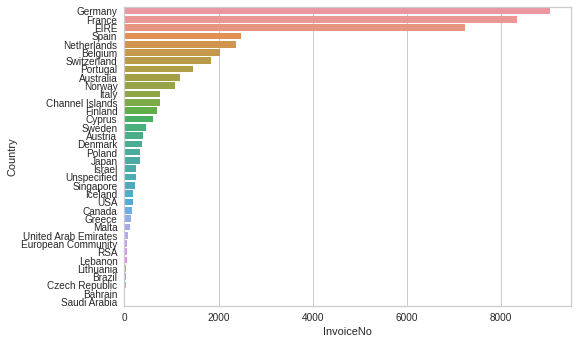

In [ ]:
#Number of Orders by Country (UK Excluded)
x = eda.groupby(by='Country', as_index=False)['InvoiceNo'].count().sort_values('InvoiceNo',ascending=False)
x = x[x['Country'] != 'United Kingdom']
sns.barplot(y='Country', x='InvoiceNo', data=x, orient='h')

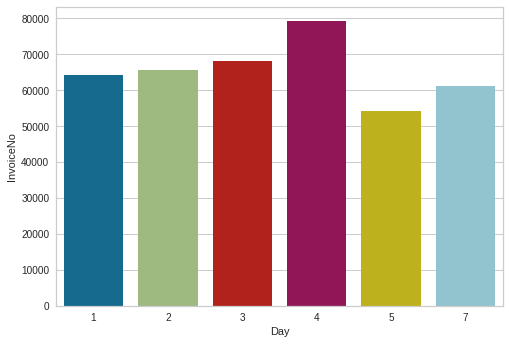

In [ ]:
#Number of Orders by Days
x = eda.groupby(by='Day', as_index=False)['InvoiceNo'].count()
sns.barplot(x='Day', y='InvoiceNo', data=x, orient='v')

No sales and number of orders on Day 6 (Saturday)

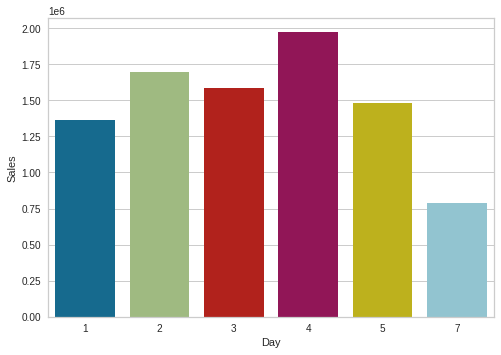

In [ ]:
#Sales by Days
x = eda.groupby(by='Day', as_index=False)['Sales'].sum()
sns.barplot(x='Day', y='Sales', data=x, orient='v')

Sales and Number of Order Peaked at Thursday(Day 4)

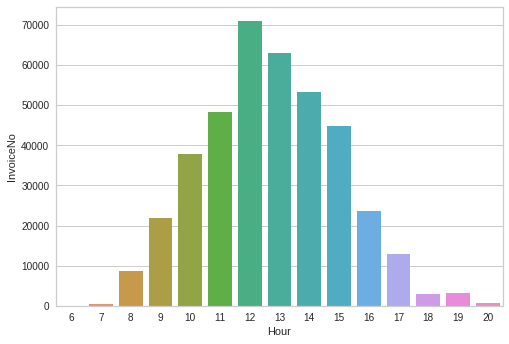

In [ ]:
#Number of Orders by Hours
x = eda.groupby(by='Hour', as_index=False)['InvoiceNo'].count()
sns.barplot(x='Hour', y='InvoiceNo', data=x, orient='v')

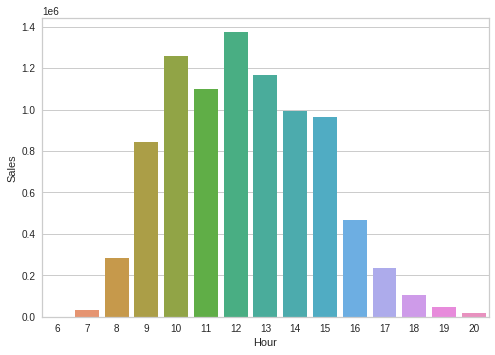

In [ ]:
#Sales by Hours
x = eda.groupby(by='Hour', as_index=False)['Sales'].sum()
sns.barplot(x='Hour', y='Sales', data=x, orient='v')

Sales and Number of Orders Peaked t 12PM

# Feature Engineering

In [ ]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [ ]:
# Create a dataframe
maxdate = df['InvoiceDate'].max()
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda invoice_date: (maxdate - invoice_date.max()).days,
                                    'InvoiceNo': lambda invoice: invoice.count(),
                                    'Sales': lambda sales: sales.sum()})

rfm.columns = ['Recency','Frequency','Monetary']
rfm = rfm.reset_index()
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12347,1,182,4310.00
2,12348,74,31,1797.24
3,12349,18,73,1757.55
4,12350,309,17,334.40


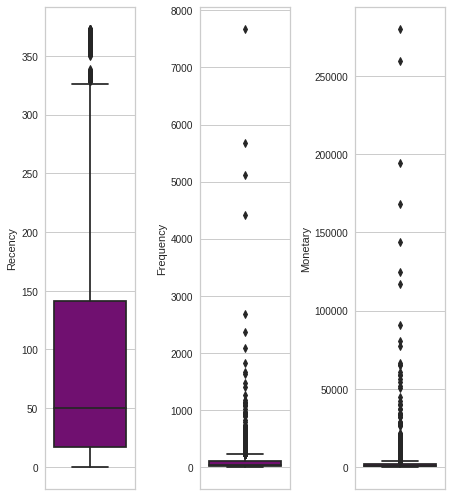

In [ ]:
#Visualize Distribution
def boxplots(df, feat_num):
  %matplotlib inline
  plt.figure(figsize=(15, 7))
  for i in range(0, len(feat_num)):
      plt.subplot(1, 7, i+1)
      sns.boxplot(y=df[feat_num[i]],color='purple',orient='v')
      plt.tight_layout()

feat_num = ['Recency','Frequency','Monetary']
boxplots(rfm, feat_num)

# Outliers Handling

In [ ]:
#Remove Outliers (IQR)
feat_num = ['Recency','Frequency','Monetary']
def remove_outliers (df,cols):
  for i in range(0, len(cols)):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
  return df

rfm = remove_outliers(rfm,feat_num)
rfm.reset_index(drop=True, inplace=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12348,74,31,1797.24
1,12349,18,73,1757.55
2,12350,309,17,334.40
3,12353,203,4,89.00
4,12354,231,58,1079.40


In [ ]:
# #Remove Outliers (Z-Score)
# feat_num = ['Recency','Frequency','Monetary']
# def remove_outliers (df,cols):
#   for i in range(0, len(cols)):
#     df = df[(np.abs(zscore(df[cols])) < 3).all(axis=1)]
#   return df

# for i in range (500):
#   rfm = remove_outliers(rfm,feat_num)
#   rfm.reset_index(drop=True, inplace=True)
#   rfm.head()

In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12348,74,31,1797.24
1,12349,18,73,1757.55
2,12350,309,17,334.40
3,12353,203,4,89.00
4,12354,231,58,1079.40


In [ ]:
rfm.describe()

,Recency,Frequency,Monetary
count,3097.000000,3097.000000,3097.000000
mean,99.093962,37.310623,622.234131
std,91.826091,29.988753,484.819074
min,0.000000,1.000000,3.750000
25%,24.000000,14.000000,244.800000
50%,64.000000,28.000000,465.680000
75%,163.000000,54.000000,876.420000
max,326.000000,127.000000,2055.510000


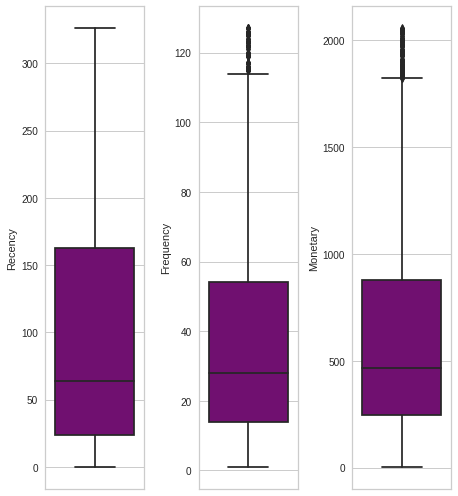

In [ ]:
#Boxplots
boxplots(rfm, feat_num)

In [ ]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3097 entries, 0 to 3096
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3097 non-null   object 
 1   Recency     3097 non-null   int64  
 2   Frequency   3097 non-null   int64  
 3   Monetary    3097 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 96.9+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

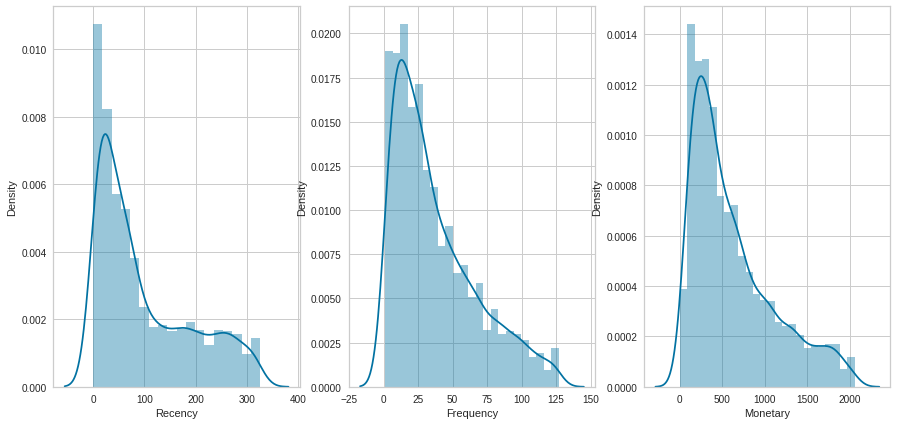

In [ ]:
#Distplots
def distplots(df, feat_num):
  %matplotlib inline
  plt.figure(figsize=(15, 7))
  for i in range(0, len(feat_num)):
      plt.subplot(1, 3, i+1)
      sns.distplot(df[feat_num[i]])

distplots(rfm, feat_num)

Skewed to the right

# Data Transformation (Log Transform and Standardization)

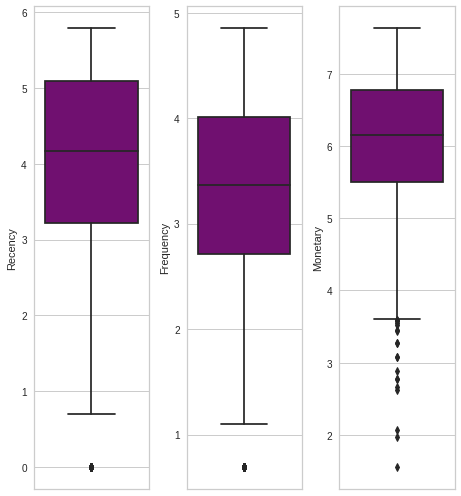

In [ ]:
#Log Transform and Standardization
rfm_log = pd.DataFrame(np.log(rfm[['Recency','Frequency','Monetary']]+1))
rfm_log.describe()

boxplots(rfm_log, rfm_log.columns)

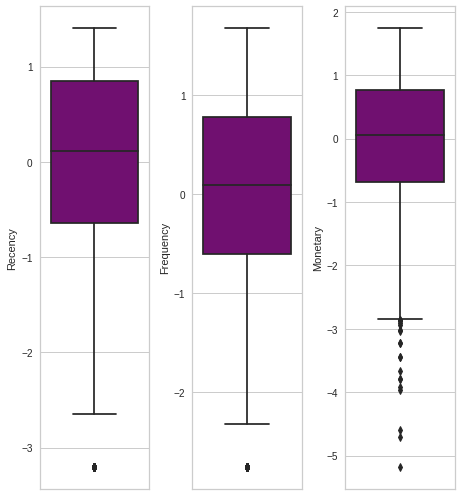

In [ ]:
scaler = StandardScaler()
rfm_log_scaled = pd.DataFrame(scaler.fit_transform(rfm_log[['Recency','Frequency','Monetary']]))
rfm_log_scaled.columns = ['Recency','Frequency','Monetary']
boxplots(rfm_log_scaled, rfm_log_scaled.columns)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

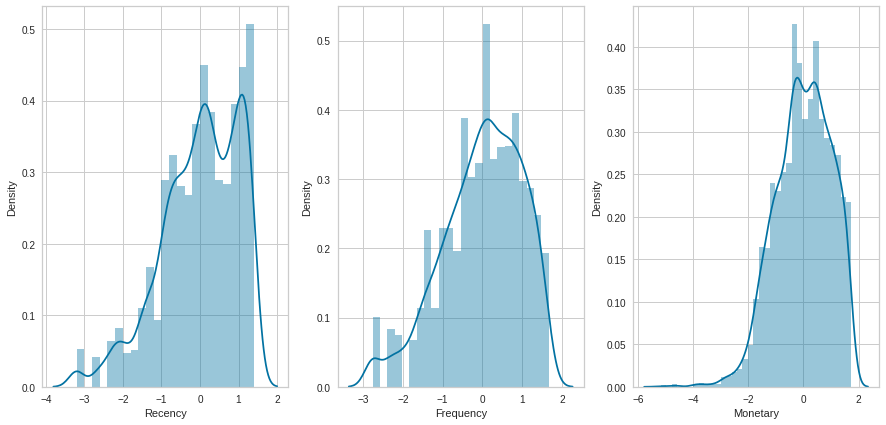

In [ ]:
distplots(rfm_log_scaled, rfm_log_scaled.columns)

In [ ]:
rfm_log_scaled.describe()

,Recency,Frequency,Monetary
count,3.097000e+03,3.097000e+03,3.097000e+03
mean,2.866164e-16,-1.671966e-16,-9.971574e-16
std,1.000161e+00,1.000161e+00,1.000161e+00
min,-3.203083e+00,-2.756398e+00,-5.176349e+00
25%,-6.426515e-01,-6.113588e-01,-6.804836e-01
50%,1.174032e-01,9.046545e-02,4.991212e-02
75%,8.535688e-01,7.718408e-01,7.691620e-01
max,1.402499e+00,1.671094e+00,1.739543e+00


# Modelling

# 1. RFM Values Clustering

In [ ]:
scaler = StandardScaler()
rfm_values = pd.DataFrame(scaler.fit_transform(rfm[['Recency','Frequency','Monetary']]))
rfm_values.columns = ['Recency','Frequency','Monetary']
rfm_values.describe()

,Recency,Frequency,Monetary
count,3.097000e+03,3.097000e+03,3.097000e+03
mean,7.273628e-17,1.813926e-17,1.026696e-16
std,1.000161e+00,1.000161e+00,1.000161e+00
min,-1.079322e+00,-1.211004e+00,-1.275907e+00
25%,-8.179167e-01,-7.774377e-01,-7.786308e-01
50%,-3.822403e-01,-3.105206e-01,-3.229646e-01
75%,6.960588e-01,5.566111e-01,5.243748e-01
max,2.471440e+00,2.991250e+00,2.956788e+00


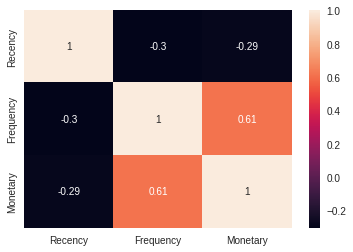

In [ ]:
sns.heatmap(rfm_values.corr(), annot=True)

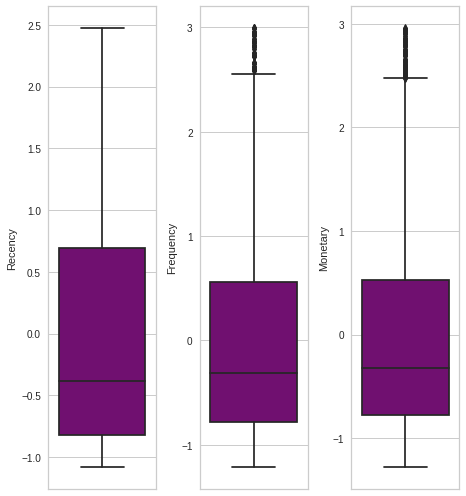

In [ ]:
boxplots(rfm_values, rfm_values.columns)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

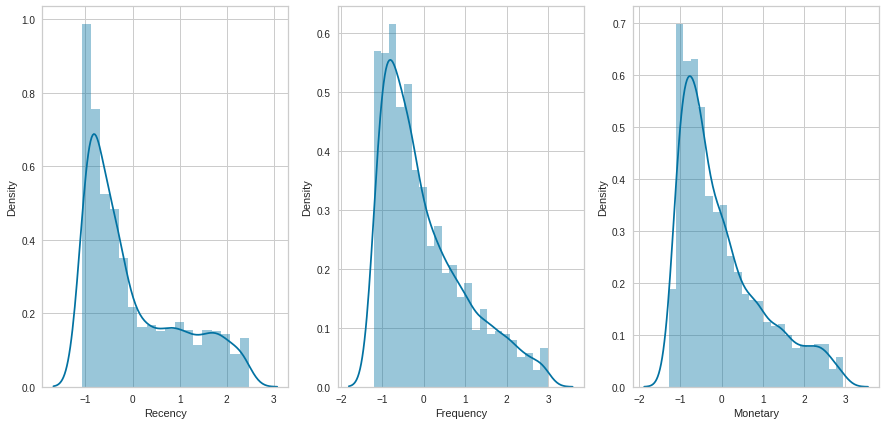

In [ ]:
distplots(rfm_values, rfm_values.columns)

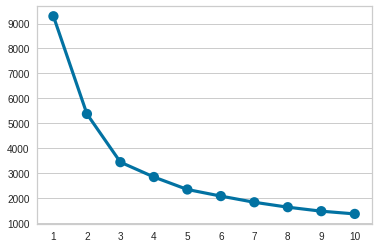

In [ ]:
#K-Means Modelling
#Elbow Method
SSE = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(rfm_values)
  SSE.append(kmeans.inertia_)

sns.pointplot(x= list(range(1,11)), y= SSE)

In [ ]:
#Silhouette Score
range_n_clusters = [3, 4, 5, 6]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(rfm_values)
    silhouette_avg = silhouette_score(rfm_values, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 3 The average silhouette_score is : 0.40824056171374695
For n_clusters = 4 The average silhouette_score is : 0.36642567703317486
For n_clusters = 5 The average silhouette_score is : 0.3968955447076123
For n_clusters = 6 The average silhouette_score is : 0.34196417205297264


n cluster = 3

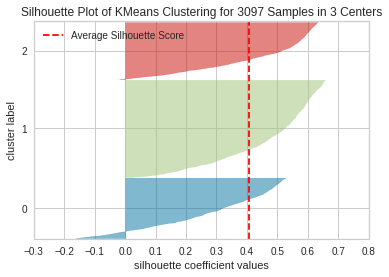

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f809edc9390>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, random_state=10))

In [ ]:
silhouette_visualizer(KMeans(3, random_state = 10), rfm_values, colors='yellowbrick')

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=10)
kmeans.fit(rfm_values)
rfm['Cluster_1'] = kmeans.labels_
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster_1
0,12348,74,31,1797.24,0
1,12349,18,73,1757.55,0
2,12350,309,17,334.40,2
3,12353,203,4,89.00,2
4,12354,231,58,1079.40,2


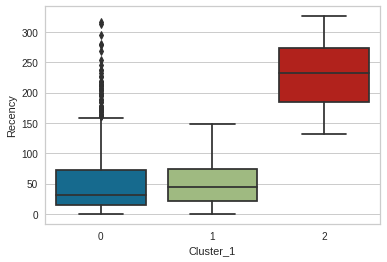

In [ ]:
sns.boxplot(x='Cluster_1', y='Recency', data = rfm)

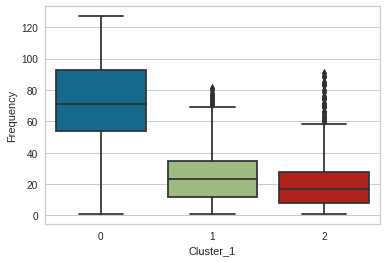

In [ ]:
sns.boxplot(x='Cluster_1', y='Frequency', data = rfm)

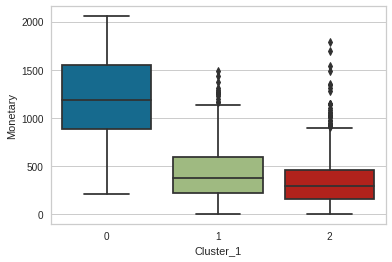

In [ ]:
#Plots
sns.boxplot(x='Cluster_1', y='Monetary', data = rfm)

Text(0.5, 0, 'Monetary')

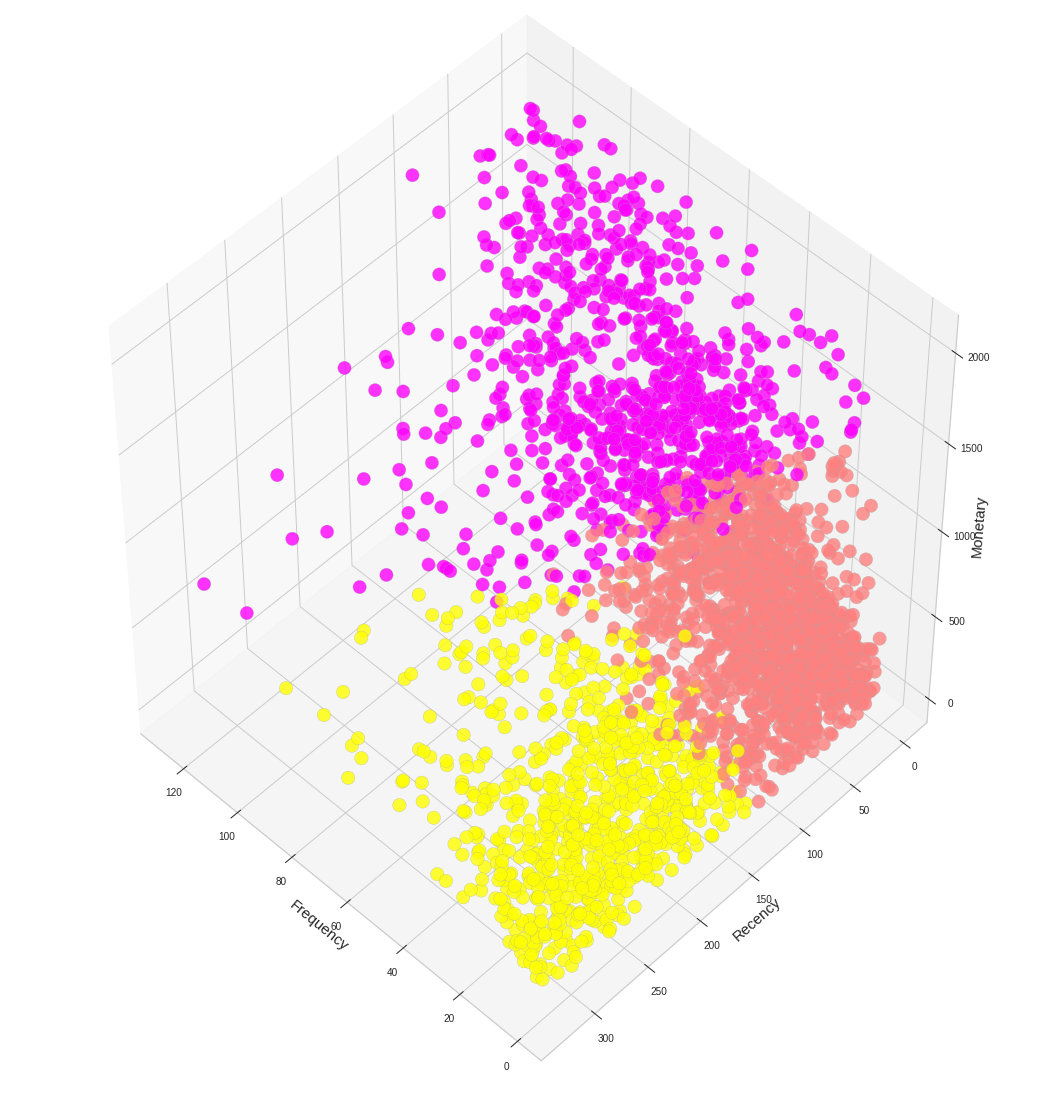

In [ ]:
#3D Chart
plt.rcParams['figure.figsize'] = (15,15)
fig = plt.figure(1)
plt.clf()
ax = Axes3D(fig,
            rect = [0,0,.95,1],
            elev = 48,
            azim = 134)

plt.cla()
ax.scatter(rfm['Frequency'],rfm['Recency'],rfm['Monetary'],
           c = rfm['Cluster_1'],
           s = 180,
           cmap = 'spring',
           alpha = 0.8,
           edgecolor = 'darkgrey')

ax.set_xlabel('Frequency',
              fontsize = 15)
ax.set_ylabel('Recency',
              fontsize = 15)
ax.set_zlabel('Monetary',
              fontsize = 15)

In [ ]:
#Scaled for visibility
rfm_copy = rfm.copy()
scaler = MinMaxScaler()
rfm_copy[['Recency','Frequency','Monetary']] = scaler.fit_transform(rfm_copy[['Recency','Frequency','Monetary']])
rfm_copy.head()

,CustomerID,Recency,Frequency,Monetary,Cluster_1
0,12348,0.226994,0.238095,0.874123,0
1,12349,0.055215,0.571429,0.854778,0
2,12350,0.947853,0.126984,0.161154,2
3,12353,0.622699,0.023810,0.041550,2
4,12354,0.708589,0.452381,0.524257,2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


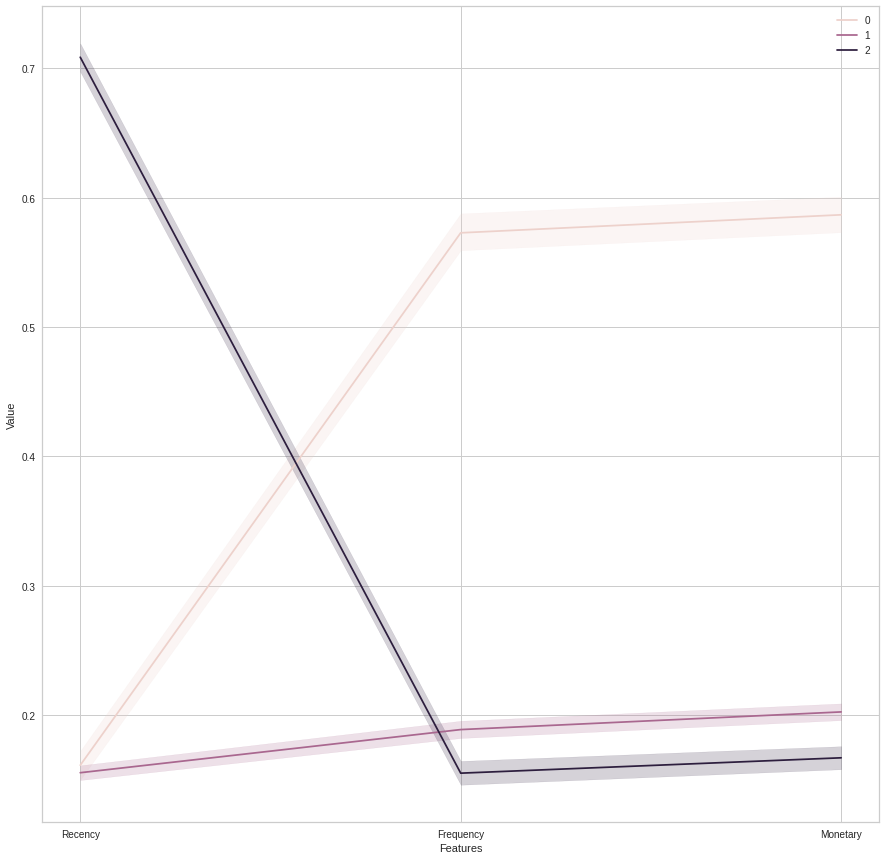

In [ ]:
#Line Plot
melted_1 = pd.melt(rfm_copy.reset_index(),
                   id_vars = ['CustomerID','Cluster_1'],
                   value_vars=['Recency','Frequency','Monetary'],
                   var_name='Features',
                   value_name='Value')
sns.lineplot('Features','Value', hue='Cluster_1', data=melted_1)
plt.legend()

In [ ]:
#Aggregates
rfm.groupby('Cluster_1').agg({
    'Recency':['mean','median','min','max'],
    'Frequency':['mean','median','min','max'],
    'Monetary':['mean','median','min','max','count']})

Recency                   ...  Monetary                       
                 mean median  min  max  ...    median     min      max count
Cluster_1                               ...                                 
0           52.583047   32.0    0  317  ...  1188.120  211.49  2055.51   873
1           50.698288   44.5    0  148  ...   371.370    6.20  1487.60  1402
2          231.034063  233.0  132  326  ...   298.055    3.75  1784.71   822

[3 rows x 13 columns]



* Cluster 0 : Recent transactions (32 days median), bought most often (73 Average) and spent the most (1200 Average), Best Customers -> Reward, can be early adopters, will likely promote, engage, ask for review, upsell higher value products


* Cluster 1 : Recent transactions (44 days median), but low transaction counts (24 Average), and spent little (419 Average), Potential and Promising -> Offer membership/loyalty program, recommend other product, start building relationship


* Cluster 2 : farthest from last transaction (231 days average), lowest transaction counts (20 average), and spent the least (346 average), Lost customers -> revive with reach-out campaigns or ignore otherwise



# 2. Transformed RFM Values Clustering

In [ ]:
rfm_log_scaled.describe()

,Recency,Frequency,Monetary
count,3.097000e+03,3.097000e+03,3.097000e+03
mean,2.866164e-16,-1.671966e-16,-9.971574e-16
std,1.000161e+00,1.000161e+00,1.000161e+00
min,-3.203083e+00,-2.756398e+00,-5.176349e+00
25%,-6.426515e-01,-6.113588e-01,-6.804836e-01
50%,1.174032e-01,9.046545e-02,4.991212e-02
75%,8.535688e-01,7.718408e-01,7.691620e-01
max,1.402499e+00,1.671094e+00,1.739543e+00


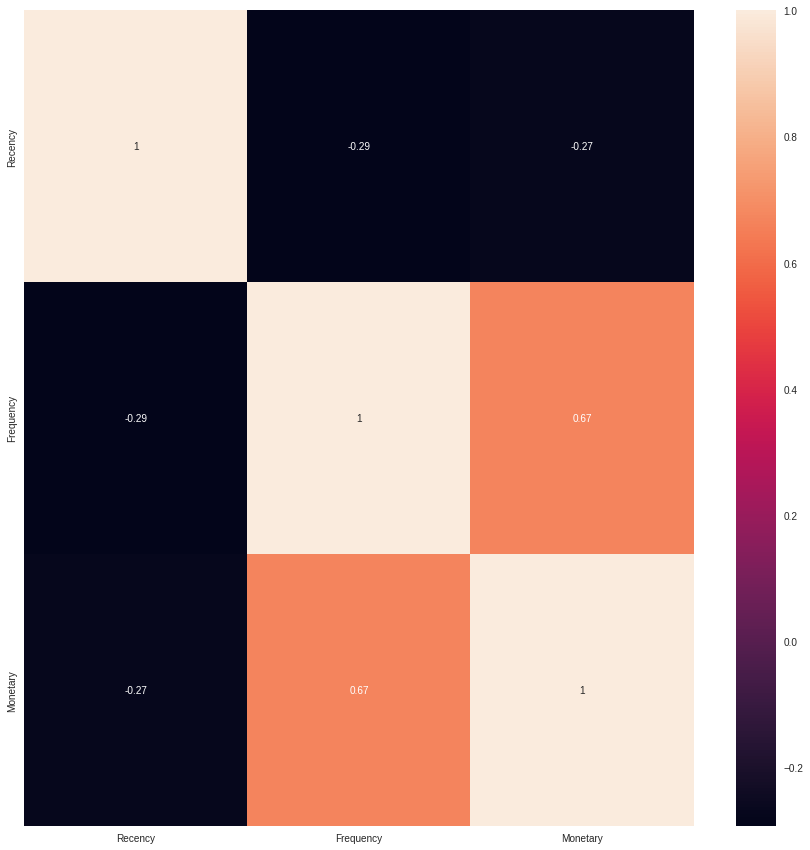

In [ ]:
sns.heatmap(rfm_log_scaled.corr(), annot=True)

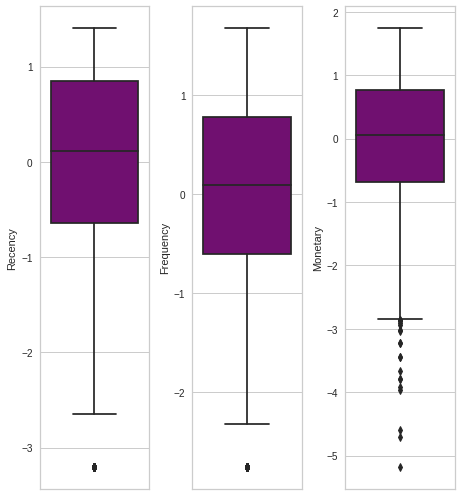

In [ ]:
boxplots(rfm_log_scaled, rfm_log_scaled.columns)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

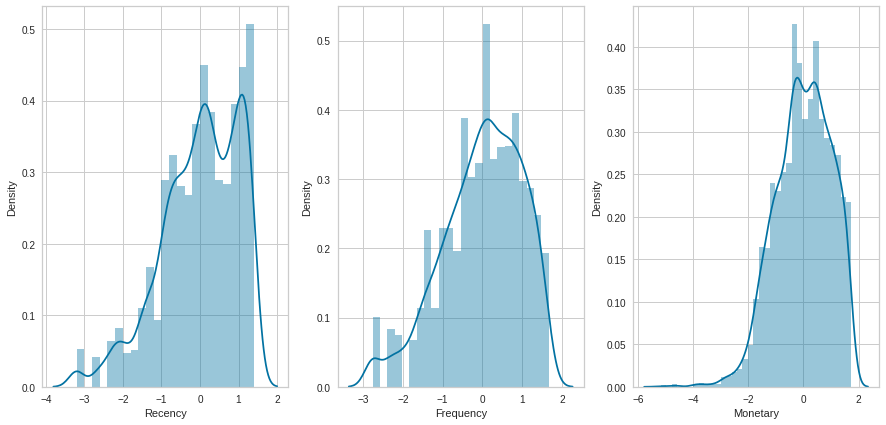

In [ ]:
distplots(rfm_log_scaled, rfm_log_scaled.columns)

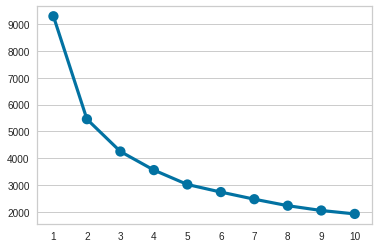

In [ ]:
#K-Means Modelling
#Elbow Method
SSE = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(rfm_log_scaled)
  SSE.append(kmeans.inertia_)

sns.pointplot(x= list(range(1,11)), y= SSE)

In [ ]:
#Silhouette Score
range_n_clusters = [2,3, 4, 5, 6]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(rfm_log_scaled)
    silhouette_avg = silhouette_score(rfm_log_scaled, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 2 The average silhouette_score is : 0.35693517630126465
For n_clusters = 3 The average silhouette_score is : 0.288040906216976
For n_clusters = 4 The average silhouette_score is : 0.26500129675703177
For n_clusters = 5 The average silhouette_score is : 0.2717953564338249
For n_clusters = 6 The average silhouette_score is : 0.2509555518114031


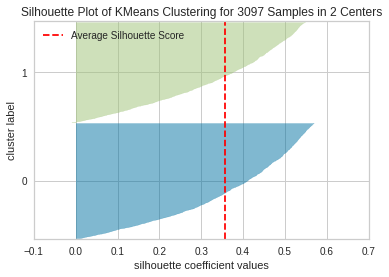

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f809e745ad0>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, random_state=10))

In [ ]:
silhouette_visualizer(KMeans(2, random_state = 10), rfm_log_scaled, colors='yellowbrick')

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=10)
kmeans.fit(rfm_log_scaled)
rfm['Cluster_2'] = kmeans.labels_
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster_1,Cluster_2
0,12348,74,31,1797.24,0,0
1,12349,18,73,1757.55,0,0
2,12350,309,17,334.40,2,1
3,12353,203,4,89.00,2,1
4,12354,231,58,1079.40,2,0


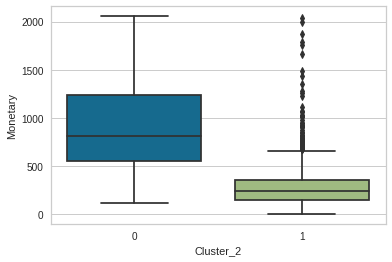

In [ ]:
#Plots
sns.boxplot(x='Cluster_2', y='Monetary', data = rfm)

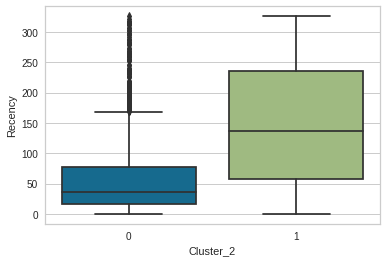

In [ ]:
sns.boxplot(x='Cluster_2', y='Recency', data = rfm)

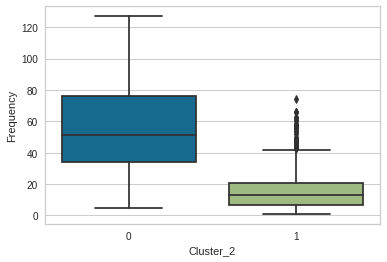

In [ ]:
sns.boxplot(x='Cluster_2', y='Frequency', data = rfm)

Text(0.5, 0, 'Monetary')

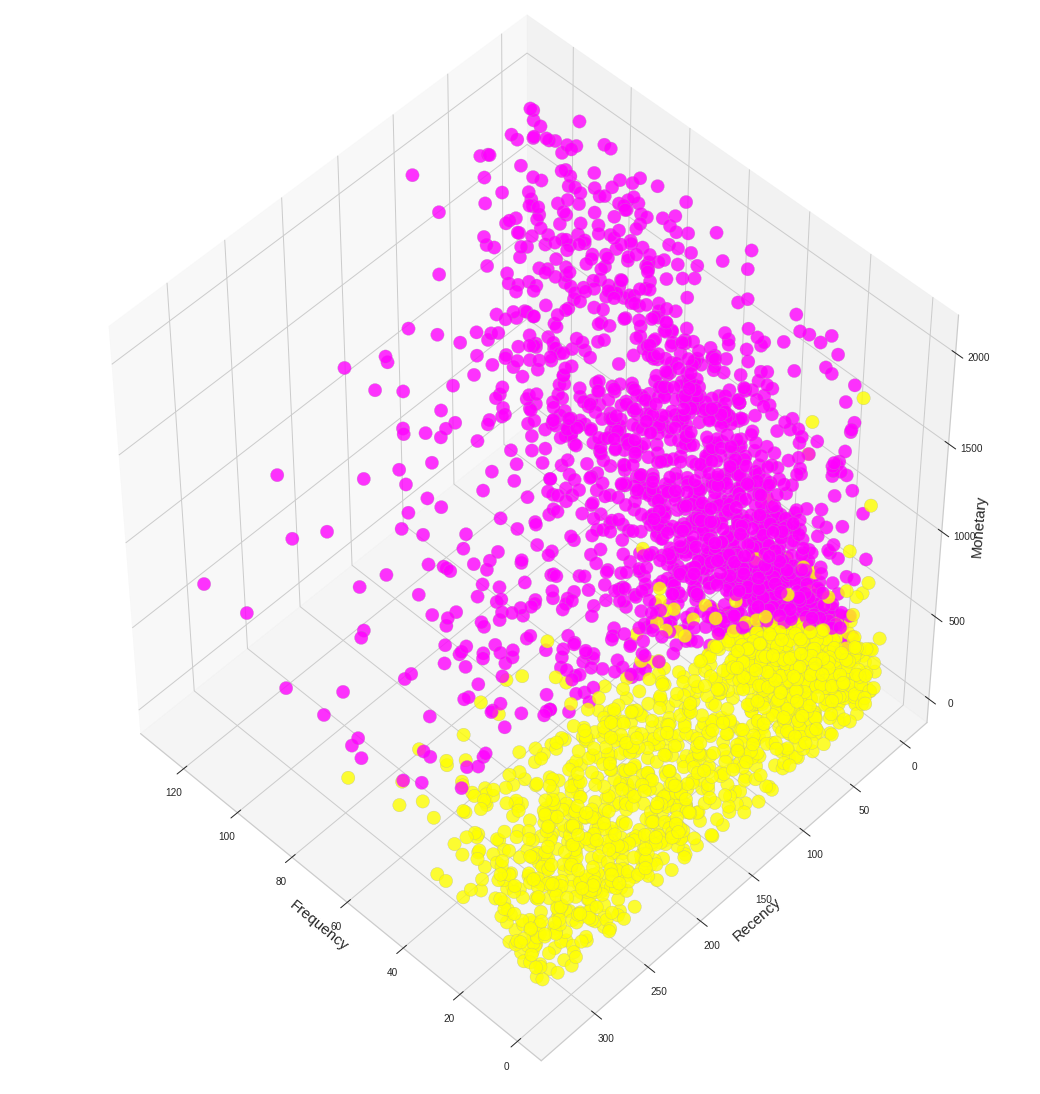

In [ ]:
#3D Chart
plt.rcParams['figure.figsize'] = (15,15)
fig = plt.figure(1)
plt.clf()
ax = Axes3D(fig,
            rect = [0,0,.95,1],
            elev = 48,
            azim = 134)

plt.cla()
ax.scatter(rfm['Frequency'],rfm['Recency'],rfm['Monetary'],
           c = rfm['Cluster_2'],
           s = 180,
           cmap = 'spring',
           alpha = 0.8,
           edgecolor = 'darkgrey')

ax.set_xlabel('Frequency',
              fontsize = 15)
ax.set_ylabel('Recency',
              fontsize = 15)
ax.set_zlabel('Monetary',
              fontsize = 15)

In [ ]:
#Scaled for visibility
rfm_copy = rfm.copy()
scaler = MinMaxScaler()
rfm_copy[['Recency','Frequency','Monetary']] = scaler.fit_transform(rfm_copy[['Recency','Frequency','Monetary']])
rfm_copy.head()

,CustomerID,Recency,Frequency,Monetary,Cluster_1,Cluster_2
0,12348,0.226994,0.238095,0.874123,0,0
1,12349,0.055215,0.571429,0.854778,0,0
2,12350,0.947853,0.126984,0.161154,2,1
3,12353,0.622699,0.023810,0.041550,2,1
4,12354,0.708589,0.452381,0.524257,2,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


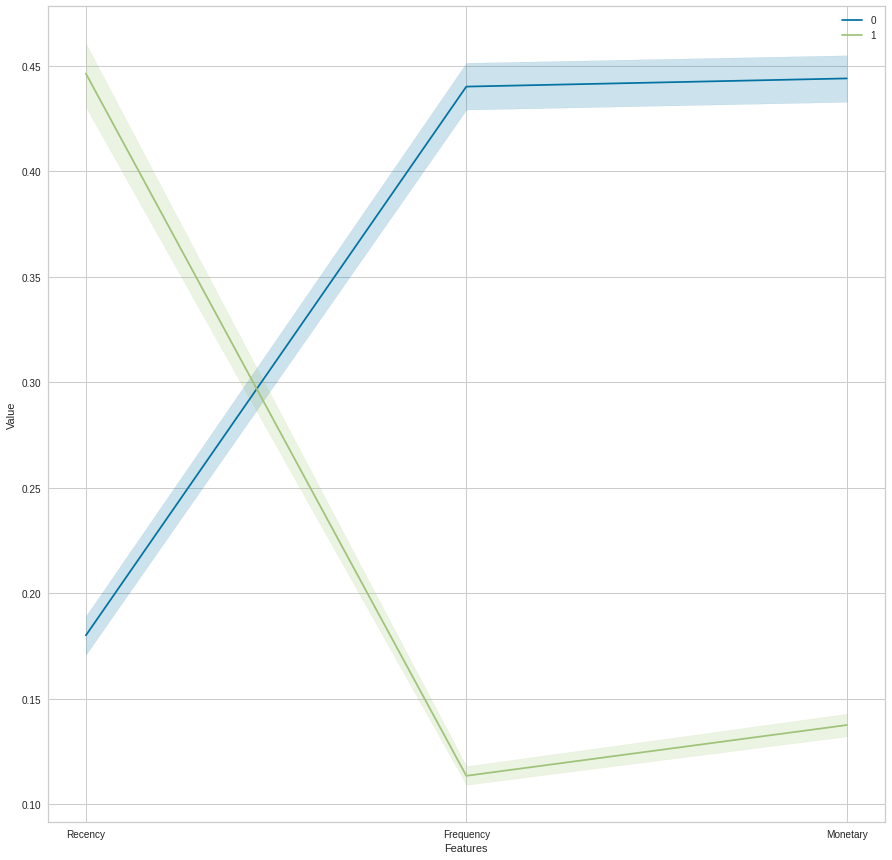

In [ ]:
#Line Plot
melted_2 = pd.melt(rfm_copy.reset_index(),
                   id_vars = ['CustomerID','Cluster_2'],
                   value_vars=['Recency','Frequency','Monetary'],
                   var_name='Features',
                   value_name='Value')
sns.lineplot('Features','Value', hue='Cluster_2', data=melted_2)
plt.legend()

In [ ]:
#Aggregates
rfm.groupby('Cluster_2').agg({
    'Recency':['mean','median','min','max'],
    'Frequency':['mean','median','min','max'],
    'Monetary':['mean','median','min','max','count']})

Recency                  ... Monetary                       
                 mean median min  max  ...   median     min      max count
Cluster_2                              ...                                
0           58.704710   36.0   0  326  ...   808.22  120.03  2055.51  1656
1          145.509368  137.0   0  326  ...   240.55    3.75  2033.10  1441

[2 rows x 13 columns]

* Cluster 0 : Recent transactions (36 days median), bought most often (56 Average) and spent the most (900 Average), Best Customers -> Reward, can be early adopters, will likely promote, engage, ask for review, upsell higher value products


* Cluster 2 : farthest from last transaction (145 days average), lowest transaction counts (15 average), and spent the least (240 average), Lost customers -> revive with reach-out campaigns or ignore otherwise

# 3. RFM Score Clustering

In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster_1,Cluster_2
0,12348,74,31,1797.24,0,0
1,12349,18,73,1757.55,0,0
2,12350,309,17,334.40,2,1
3,12353,203,4,89.00,2,1
4,12354,231,58,1079.40,2,0


In [ ]:
#RFM Scoring
rfm['R Score'] = pd.qcut(rfm['Recency'],5,labels=[5,4,3,2,1])
rfm['F Score'] = pd.qcut(rfm['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])
rfm['M Score'] = pd.qcut(rfm['Monetary'],5,labels=[1,2,3,4,5])
rfm['RFM'] = (rfm['R Score'].astype(str)+ rfm['F Score'].astype(str) + rfm['M Score'].astype(str))
rfm['R Score'] = pd.to_numeric(rfm['R Score'])
rfm['F Score'] = pd.to_numeric(rfm['F Score'])
rfm['M Score'] = pd.to_numeric(rfm['M Score'])
rfm['RFM'] = pd.to_numeric(rfm['RFM'])
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster_1,Cluster_2,R Score,F Score,M Score,RFM
0,12348,74,31,1797.24,0,0,3,3,5,335
1,12349,18,73,1757.55,0,0,5,5,5,555
2,12350,309,17,334.40,2,1,1,2,2,122
3,12353,203,4,89.00,2,1,1,1,1,111
4,12354,231,58,1079.40,2,0,1,4,5,145


In [ ]:
#RFM Scoring Scale
rfm.groupby('R Score').agg({'Recency': ['min', 'max','mean','median']})

Recency                        
            min  max        mean median
R Score                                
1           191  326  255.503247  255.0
2            87  190  135.823339  133.0
3            47   86   65.048622   64.0
4            20   46   31.355662   30.0
5             0   19    9.525806    9.0

In [ ]:
rfm.groupby('F Score').agg({'Frequency': ['min', 'max','mean','median']})

Frequency                       
              min  max       mean median
F Score                                 
1               1   11   6.172581    6.0
2              11   22  16.413570   16.0
3              22   37  28.680129   28.0
4              37   62  48.127625   47.0
5              62  127  87.129032   84.0

In [ ]:
rfm.groupby('M Score').agg({'Monetary': ['min', 'max','mean','median']})

Monetary                                
             min      max         mean    median
M Score                                         
1           3.75   205.70   133.295694   138.020
2         206.21   363.65   286.917161   294.180
3         363.70   605.12   473.444259   465.780
4         605.58  1018.71   779.562877   763.640
5        1019.52  2055.51  1437.724452  1385.185

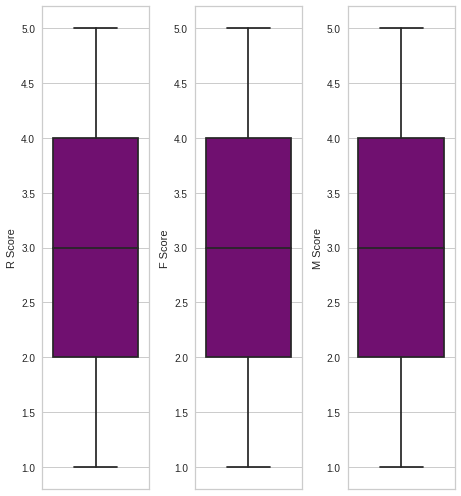

In [ ]:
#Plots
boxplots(rfm[['R Score','F Score','M Score']],rfm[['R Score','F Score','M Score']].columns)

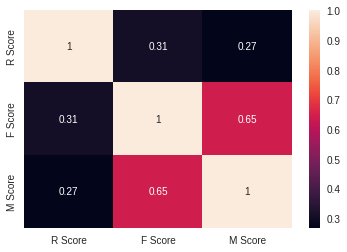

In [ ]:
sns.heatmap(rfm.iloc[:, 6:9].corr(), annot=True)

In [ ]:
rfm_data = rfm.iloc[:, 6:9]
rfm_data.head()

,R Score,F Score,M Score
0,3,3,5
1,5,5,5
2,1,2,2
3,1,1,1
4,1,4,5


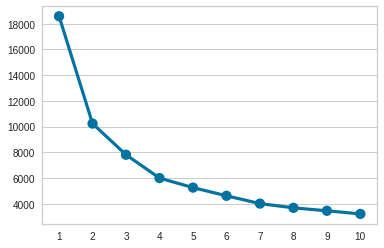

In [ ]:
#K-Means Modelling
#Elbow Method
SSE = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, random_state=10).fit(rfm_data)
  SSE.append(kmeans.inertia_)

sns.pointplot(x= list(range(1,11)), y= SSE)

In [ ]:
#Silhouette Score
range_n_clusters = [4, 5]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(rfm_data)
    silhouette_avg = silhouette_score(rfm_data, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 4 The average silhouette_score is : 0.34694212888090464
For n_clusters = 5 The average silhouette_score is : 0.3322515358456195


n cluster = 4

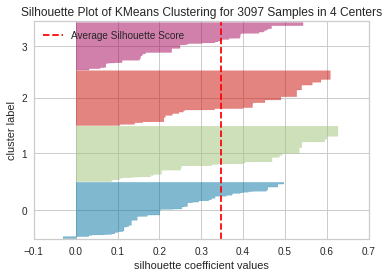

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f809f11d910>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=10))

In [ ]:
silhouette_visualizer(KMeans(4, random_state = 10), rfm_data, colors='yellowbrick')

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=10)
kmeans.fit(rfm_data)
rfm['Cluster_3'] = kmeans.labels_
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster_1,Cluster_2,R Score,F Score,M Score,RFM,Cluster_3
0,12348,74,31,1797.24,0,0,3,3,5,335,0
1,12349,18,73,1757.55,0,0,5,5,5,555,2
2,12350,309,17,334.40,2,1,1,2,2,122,1
3,12353,203,4,89.00,2,1,1,1,1,111,1
4,12354,231,58,1079.40,2,0,1,4,5,145,0


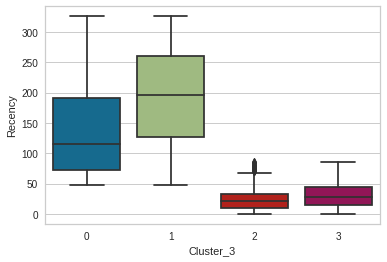

In [ ]:
sns.boxplot(x='Cluster_3', y='Recency', data = rfm)

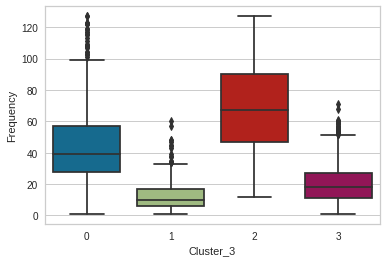

In [ ]:
sns.boxplot(x='Cluster_3', y='Frequency', data = rfm)

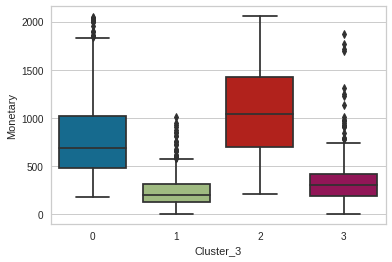

In [ ]:
sns.boxplot(x='Cluster_3', y='Monetary', data = rfm)

No handles with labels found to put in legend.


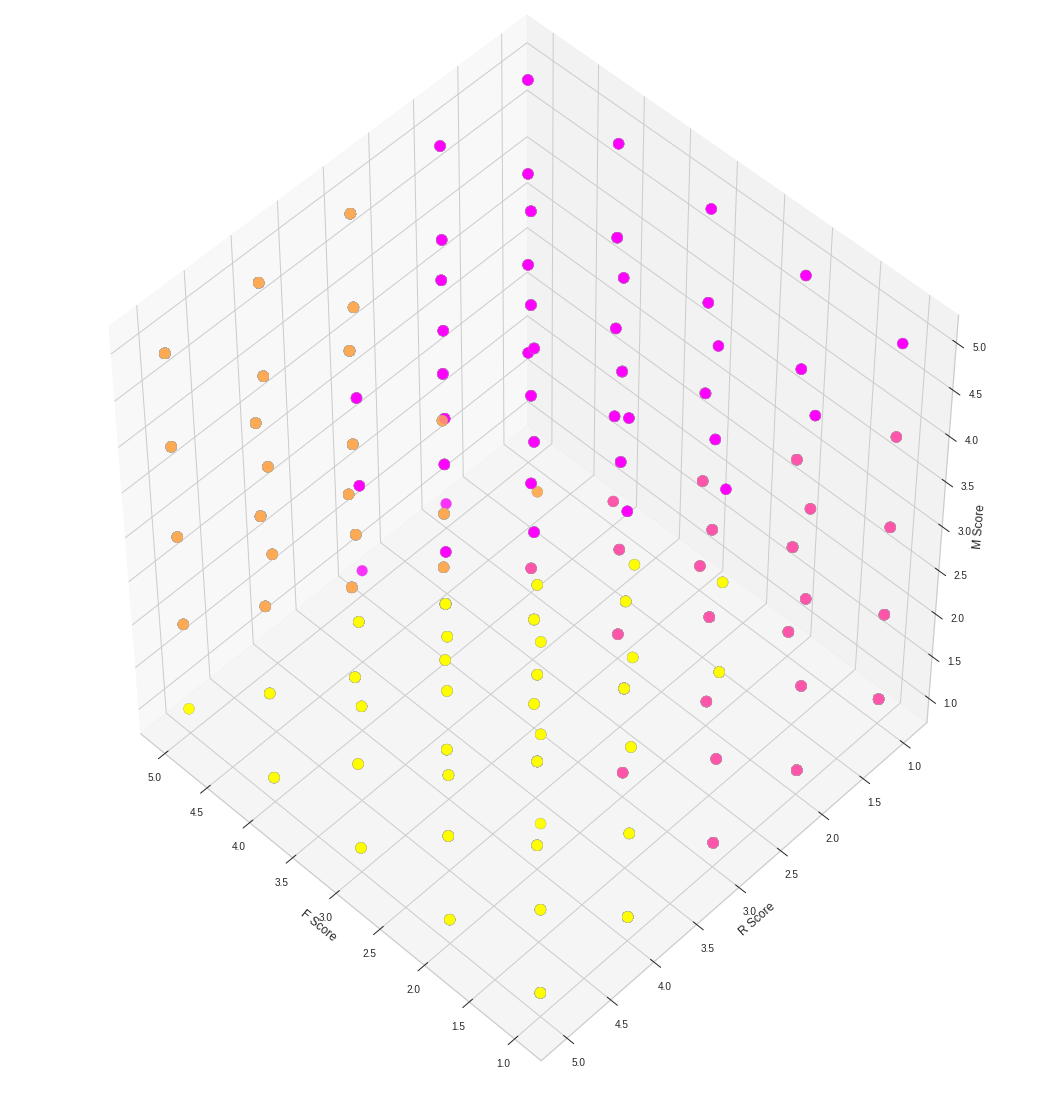

In [ ]:
#3D Chart
plt.rcParams['figure.figsize'] = (15,15)
fig = plt.figure(1)
plt.clf()
ax = Axes3D(fig,
            rect = [0,0,.95,1],
            elev = 48,
            azim = 134)

plt.cla()
ax.scatter(rfm['F Score'],rfm['R Score'],rfm['M Score'],
           c = rfm['Cluster_3'],
           s = 120,
           cmap = 'spring',
           alpha = 0.8,
           edgecolor = 'darkgrey')

ax.set_xlabel('F Score',
              fontsize = 12)
ax.set_ylabel('R Score',
              fontsize = 12)
ax.set_zlabel('M Score',
              fontsize = 12)
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


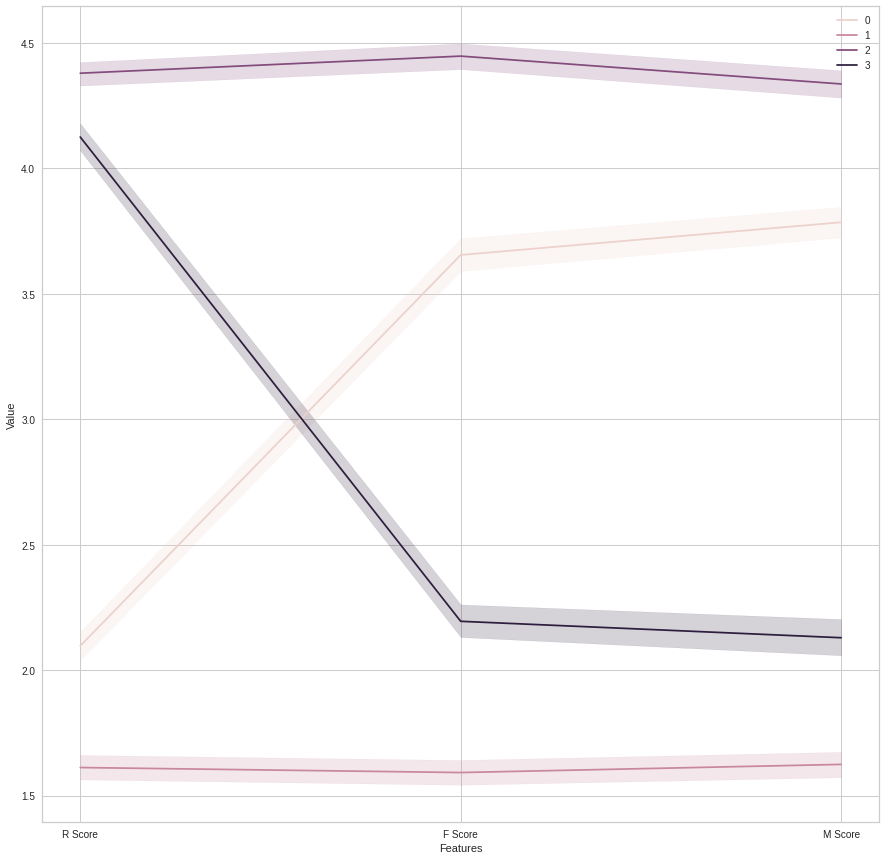

In [ ]:
#Line Plot
melted_3 = pd.melt(rfm.reset_index(),
                   id_vars = ['CustomerID','Cluster_3'],
                   value_vars=['R Score','F Score','M Score'],
                   var_name='Features',
                   value_name='Value')
sns.lineplot('Features','Value', hue='Cluster_3', data=melted_3)
plt.legend()

In [ ]:
#Aggregates
rfm.groupby('Cluster_3').agg({
    'Recency':['mean','median','min','max'],
    'Frequency':['mean','median','min','max'],
    'Monetary':['mean','median','min','max','count']})

Recency                  ...  Monetary                       
                 mean median min  max  ...    median     min      max count
Cluster_3                              ...                                 
0          138.209816  115.0  47  326  ...   683.170  179.93  2044.37   815
1          191.704489  196.5  48  326  ...   199.825    3.75  1012.00   802
2           23.593947   21.0   0   86  ...  1035.800  210.31  2055.51   793
3           31.726346   28.0   0   86  ...   301.720    6.90  1873.20   687

[4 rows x 13 columns]



* Cluster 0 : Has been a while since last transaction (138 days average), bought pretty often (45 Average) and spent a lot (797 Average), At Risk customers -> reconnect and reactivate, limited time offers, provide helpful resources, recommend based on past purchase, important to retain


* Cluster 1 : last transaction is so far behind (190 days average), low transaction counts (12 Average), and spent the least (232 Average), Lost customers -> revive with reach-out campaigns or ignore otherwise


* Cluster 2 : last transaction is the most recent (20 days average), highest transaction counts (69 average), and spent the most(1085 average), Best Customers -> Reward, can be early adopters, will likely promote, engage, ask for review, upsell higher value products


* Cluster 3 : last transaction is pretty recent (31 days average), but low transaction counts (20 average) and spending (334 average), Potential and Promising -> Offer membership/loyalty program, recommend other product, start building relationship



# 4. RFM Segments

In [ ]:
def segment_me(rfm):
  if rfm['RFM'] in [555,554,544,545,454,455,445]:
    return 'Champions'
  elif rfm['RFM'] in [543,444,435,355,354,345,344,335]:
    return 'Loyal'
  elif rfm['RFM'] in [553,551,552,541,542,533,532,531,452,451,442,441,431,453,433,432,423,353,352,351,342,341,333,323]:
    return 'Potential Loyalist'
  elif rfm['RFM'] in [512,511,422,421,412,411,311]:
    return 'New Customers'
  elif rfm['RFM'] in [525,524,523,522,521,515,514,513,425,424,413,414,415,315,314,313]:
    return 'Promising'
  elif rfm['RFM'] in [535,534,443,434,434,343,334,325,324]:
    return 'Need Attention'
  elif rfm['RFM'] in [331,321,312,221,213,231,241,251]:
    return 'About to Sleep'
  elif rfm['RFM'] in [255,254,245,244,253,252,243,242,235,234,225,224,153,152,145,143,142,135,134,133,125,124]:
    return 'At Risk'
  elif rfm['RFM'] in [155,154,144,214,215,115,114,113]:
    return 'Cannot Lose Them'
  elif rfm['RFM'] in [332,322,233,232,223,222,132,123,122,212,211]:
    return 'Hibernating Customers'
  elif rfm['RFM'] in [111,112,121,131,141,151]:
    return 'Lost Customers'

In [ ]:
#Segmenting
rfm['Customer Segment'] = rfm.apply(segment_me, axis=1)
rfm.head(10)

,CustomerID,Recency,Frequency,Monetary,Cluster_1,Cluster_2,R Score,F Score,M Score,RFM,Cluster_3,Customer Segment
0,12348,74,31,1797.24,0,0,3,3,5,335,0,Loyal
1,12349,18,73,1757.55,0,0,5,5,5,555,2,Champions
2,12350,309,17,334.40,2,1,1,2,2,122,1,Hibernating Customers
3,12353,203,4,89.00,2,1,1,1,1,111,1,Lost Customers
4,12354,231,58,1079.40,2,0,1,4,5,145,0,At Risk
5,12355,213,13,459.40,2,1,1,2,3,123,1,Hibernating Customers
6,12358,1,19,1168.06,1,0,5,2,5,525,2,Promising
7,12361,286,10,189.90,2,1,1,1,1,111,1,Lost Customers
8,12363,109,23,552.00,1,1,2,3,3,233,0,Hibernating Customers
9,12364,7,85,1313.10,0,0,5,5,5,555,2,Champions


In [ ]:
segment_df = rfm.groupby(by=['Customer Segment'],as_index=False)['CustomerID'].count()
segment_df = segment_df.rename(columns = {'CustomerID':'Number of Customers'})
segment_df.sort_values('Number of Customers', ascending=False)

,Customer Segment,Number of Customers
4,Hibernating Customers,488
3,Champions,462
1,At Risk,417
9,Potential Loyalist,411
6,Loyal,280
8,New Customers,250
5,Lost Customers,246
10,Promising,171
7,Need Attention,161
0,About to Sleep,119


In [ ]:
#Basic Treemap
fig = px.treemap(segment_df,path=['Customer Segment'], values='Number of Customers')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [ ]:
#Stats
rfm.groupby('Customer Segment').agg({
    'Recency':['mean','min','max'],
    'Frequency':['mean','min','max'],
    'Monetary':['mean','min','max','count']})

Recency            ... Monetary               
                             mean  min  max  ...      min      max count
Customer Segment                             ...                        
About to Sleep         109.756303   49  189  ...    52.83   594.00   119
At Risk                174.779376   87  326  ...   208.65  2044.37   417
Cannot Lose Them       221.782609   89  325  ...   370.80  2040.10    92
Champions               17.590909    0   46  ...   607.53  2054.36   462
Hibernating Customers  162.817623   49  325  ...    15.00   605.06   488
Lost Customers         258.890244  191  326  ...     3.75   357.98   246
Loyal                   54.153571    0   86  ...   365.76  2055.51   280
Need Attention          41.093168    1   85  ...   366.85  2020.52   161
New Customers           34.432000    0   86  ...     6.20   360.00   250
Potential Loyalist      35.489051    0   86  ...   107.82   604.51   411
Promising               25.169591    0   86  ...   125.22  2033.10   171

[11 rows x 10 columns]

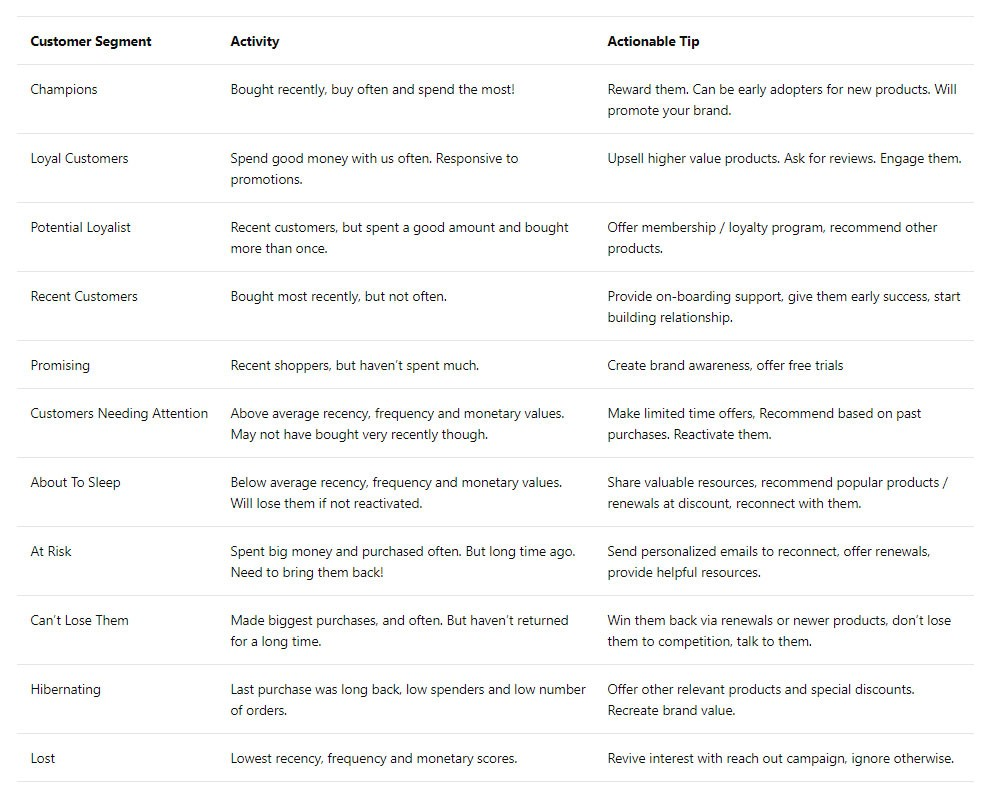

# Export to .csv

In [ ]:
rfm.to_csv('rfm_segmentation1.csv', index=False)
eda.to_csv('eda.csv', index=False)